# Adaptive optics with a Shack-Hartmann wavefront sensor

We will simulate a closed-loop adaptive optics system, based on the the Spectro-Polarimetric High-contrast Exoplanet REsearch (SPHERE) adaptive optics (AO) system, that uses a Shack-Hartmann WFS. We will simulate calibration and on-sky operation of this simulated AO system.

We first start by importing the relevant python modules.

In [1]:
from hcipy import *
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import time
import os

%matplotlib inline

## Simulating the VLT pupil

We will model here the VLT pupil, of 8m in diameter (the primary mirror is 8.2m but the actual pupil is restricted by M2 to 8m, there is an extra margin used for choping in the infrared).

In [2]:
telescope_diameter = 8. # meter
central_obscuration = 1.2 # meter
central_obscuration_ratio = central_obscuration / telescope_diameter
spider_width = 0.05 # meter
oversizing_factor = 16 / 15

We represent the pupil by a grid of 240px. This is the sampling used by the SH WFS of SPHERE, which is an EMCCD of 240x240px (6px per subapertures, with 40 subapertures on one diameter). 
To avoid some numerical problems at the edges, we oversize the pupil grid by a factor 16 / 15, e.g. the grid is represented by a grid of 240 * 16 / 15 = 256 px.

In [3]:
num_pupil_pixels = 240 * oversizing_factor
pupil_grid_diameter = telescope_diameter * oversizing_factor
pupil_grid = make_pupil_grid(num_pupil_pixels, pupil_grid_diameter)

VLT_aperture_generator = make_obstructed_circular_aperture(telescope_diameter,
    central_obscuration_ratio, num_spiders=4, spider_width=spider_width)

VLT_aperture = evaluate_supersampled(VLT_aperture_generator, pupil_grid, 4)

The factor 4 indicates that each pixel will be evaluated with 4x supersampling, effectively averaging 4x4=16 subpixels for each pixel.

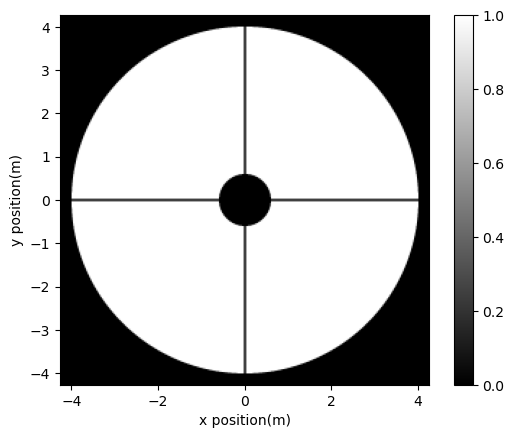

In [4]:
imshow_field(VLT_aperture, cmap='gray')
plt.xlabel('x position(m)')
plt.ylabel('y position(m)')
plt.colorbar()
plt.show()

As shown above, the pupil is not exactly that of the VLT (the 4 spiders of the VLT intersect on the perimetre of M2, and not at the center), but this is not important here.

## Incoming wavefront

Let's assume we work with monochromatic light at 700nm for wavefront sensing and in the K band at 2.2 micron for the scientific channel

In [5]:
wavelength_wfs = 0.7e-6
wavelength_sci = 2.2e-6
wf = Wavefront(VLT_aperture, wavelength_sci)
wf.total_power = 1

Let visualize the corresponding diffraction pattern. To do so, we need to propagate the wavefront from the pupil to a focal plane. We assume here a perfect lens (see :class:`FraunhoferPropagator` for details on the model).

We also need to sample the electric field on a focal plane. We use here 4 pixels per resolution elements and set the field of view to 30 lambda/D in radius at the science wavelength.

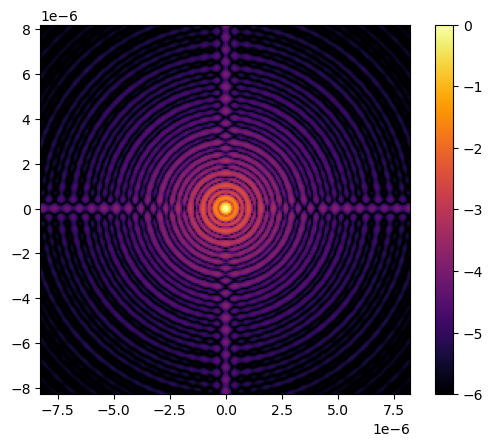

In [6]:
spatial_resolution = wavelength_sci / telescope_diameter
focal_grid = make_focal_grid(q=4, num_airy=30, spatial_resolution=spatial_resolution)

propagator = FraunhoferPropagator(pupil_grid, focal_grid)

unaberrated_PSF = propagator.forward(wf).power

imshow_field(np.log10(unaberrated_PSF / unaberrated_PSF.max()), cmap='inferno', vmin=-6)
plt.colorbar()
plt.show()

## Wavefront sensor

The WFS is a squared 40x40 Shack Hartmann WFS. The diameter of the beam needs to be reshaped with a magnifier, otherwise the spots are not resolved by the pupil grid: the spots have a size of $F \lambda = 35\mathrm{\mu m}$ with a F-ratio of 50. If the beam is 5mm, then 1px is 20 micron and we resolve the spots, albeit barely.

In [7]:
f_number = 50
num_lenslets = 40 # 40 lenslets along one diameter
sh_diameter = 5e-3 # m

magnification = sh_diameter / telescope_diameter
magnifier = Magnifier(magnification)

In [8]:
shwfs = SquareShackHartmannWavefrontSensorOptics(pupil_grid.scaled(magnification), f_number, \
                                                 num_lenslets, sh_diameter)
shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index)

We assume a noiseless detector. In practice the EMCCD of SPHERE has RON of about 1 electron.

In [9]:
camera = NoiselessDetector(focal_grid)

Let's look at the SH image for an undisturbed wavefront

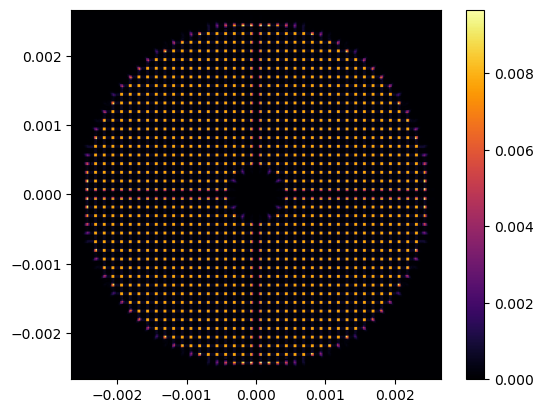

In [10]:
wf = Wavefront(VLT_aperture, wavelength_wfs)
camera.integrate(shwfs(magnifier(wf)), 1)

image_ref = camera.read_out()

imshow_field(image_ref, cmap='inferno')
plt.colorbar()
plt.show()

And zooming in a bit on some of the spots to see a little more detail...

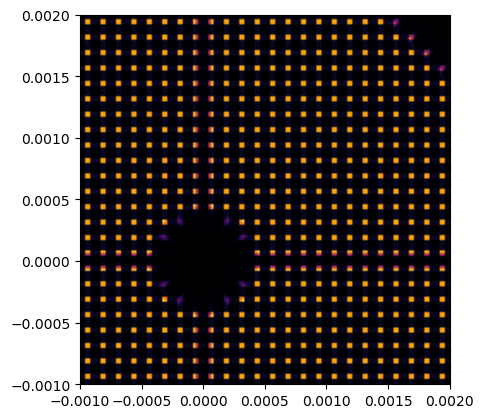

In [11]:
imshow_field(image_ref, cmap='inferno')
plt.xlim(-0.001, 0.002)
plt.ylim(-0.001, 0.002)
plt.show()

We select subapertures to use for wavefront sensing, based on their flux. The sub-pupils seeing the spiders receive about 85% of the flux of the unobscured sup-apertures. We want to include those, but we do not want to incldues superatures at the edge of the pupil that receive less than 75% of that flux. We therefore use a threshold at 75%.



In [18]:
fluxes = ndimage.sum(image_ref, shwfse.mla_index, shwfse.estimation_subapertures)
flux_limit = fluxes.max() * 0.75

estimation_subapertures = shwfs.mla_grid.zeros(dtype='bool')
estimation_subapertures[shwfse.estimation_subapertures[fluxes > flux_limit]] = True

shwfse = ShackHartmannWavefrontSensorEstimator(shwfs.mla_grid, shwfs.micro_lens_array.mla_index, estimation_subapertures)

Calculate reference slopes.

In [ ]:
slopes_ref = shwfse.estimate([image_ref])

## Deformable mirror

Let's assume we control 500 disk harmonic modes with the DM.

In [ ]:
num_modes = 500

dm_modes = make_disk_harmonic_basis(pupil_grid, num_modes, telescope_diameter, 'neumann')
dm_modes = ModeBasis([mode / np.ptp(mode) for mode in dm_modes], pupil_grid)

deformable_mirror = DeformableMirror(dm_modes)

## Calibrating the interaction matrix

Then we need to calibrate the interaction matrix: you excite individually each mode of the DM and estimate the centroids of the spots.

In [ ]:
probe_amp = 0.01 * wavelength_wfs
response_matrix = []

wf = Wavefront(VLT_aperture, wavelength_wfs)
wf.total_power = 1

# Set up animation
plt.figure(figsize=(10, 6))
anim = FFMpegWriter('response_matrix.mp4', framerate=5)

for i in tqdm(range(num_modes)):
    slope = 0

    # Probe the phase response
    amps = [-probe_amp, probe_amp]
    for amp in amps:
        deformable_mirror.flatten()
        deformable_mirror.actuators[i] = amp

        dm_wf = deformable_mirror.forward(wf)
        wfs_wf = shwfs(magnifier(dm_wf))

        camera.integrate(wfs_wf, 1)
        image = camera.read_out()

        slopes = shwfse.estimate([image])

        slope += amp * slopes / np.var(amps)

    response_matrix.append(slope.ravel())

    # Only show all modes for the first 40 modes
    if i > 40 and (i + 1) % 20 != 0:
        continue

    # Plot mode response
    plt.clf()
    plt.suptitle('Mode %d / %d: DM shape' % (i + 1, num_modes))

    plt.subplot(1,2,1)
    plt.title('DM surface')
    im1 = imshow_field(deformable_mirror.surface, cmap='RdBu', mask=VLT_aperture)

    plt.subplot(1,2,2)
    plt.title('SH spots')
    im2 = imshow_field(image)
    plt.quiver(shwfs.mla_grid.subset(shwfse.estimation_subapertures).x,
        shwfs.mla_grid.subset(shwfse.estimation_subapertures).y,
        slope[0,:], slope[1,:],
        color='white')

    anim.add_frame()

response_matrix = ModeBasis(response_matrix)

plt.close()
anim.close()

# Show created animation
anim

We invert the interaction matrix using Tikhonov regularisation

In [ ]:
rcond = 1e-3

reconstruction_matrix = inverse_tikhonov(response_matrix.transformation_matrix, rcond=rcond)
print(reconstruction_matrix.shape)

We initialise the DM with a random position by setting the DM actuators at random values.

In [ ]:
# Put actuators at random values, putting a little more power in low-order modes
deformable_mirror.actuators = np.random.randn(num_modes) / (np.arange(num_modes) + 10)

# Normalize the DM surface so that we get a reasonable surface RMS.
deformable_mirror.actuators *= 0.3 * wavelength_sci / np.std(deformable_mirror.surface)

imshow_field(deformable_mirror.phase_for(wavelength_wfs), mask=VLT_aperture, cmap='RdBu')
plt.colorbar()
plt.show()

## Closing the loop without atmospheric disturbance

In [ ]:
zero_magnitude_flux = 3.9e10 #3.9e10 photon/s for a mag 0 star
stellar_magnitude = 5
delta_t = 1e-3 # sec, so a loop speed of 1kHz.

wf_wfs = Wavefront(VLT_aperture, wavelength_wfs)
wf_sci = Wavefront(VLT_aperture, wavelength_sci)

wf_wfs.total_power = zero_magnitude_flux * 10**(-stellar_magnitude / 2.5)
wf_sci.total_power = zero_magnitude_flux * 10**(-stellar_magnitude / 2.5)

print("Photon flux per WFS frame {:g}".format(wf_wfs.total_power * delta_t))

In [ ]:
deformable_mirror.actuators = np.random.randn(num_modes) / (np.arange(num_modes) + 10)
deformable_mirror.actuators *= 0.3 * wavelength_sci / np.std(deformable_mirror.surface)

gain = 0.6
leakage = 0.01
num_iterations = 20

long_exposure = 0

# Set up animation
plt.figure(figsize=(8, 8))
anim = FFMpegWriter('AO_simulation_without_turbulence.mp4', framerate=10)

for timestep in tqdm(range(num_iterations)):
    # Propagate through SH-WFS
    wf_after_sh = shwfs(magnifier(deformable_mirror(wf_wfs)))

    # Propagate the NIR wavefront
    wf_sci_after_dm = propagator(deformable_mirror(wf_sci))

    # Read out WFS camera
    camera.integrate(wf_after_sh, delta_t)
    wfs_image = camera.read_out()
    wfs_image = large_poisson(wfs_image).astype('float')

    # Calculate slopes from WFS image
    slopes = shwfse.estimate([wfs_image + 1e-10])
    slopes -= slopes_ref
    slopes = slopes.ravel()

    # Perform wavefront control and set DM actuators
    deformable_mirror.actuators = (1 - leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(slopes)

    # Plotting
    plt.clf()
    plt.suptitle('Timestep %d / %d' % (timestep, num_iterations))

    plt.subplot(2,2,1)
    plt.title('DM surface [$\\mu$m]')
    imshow_field(deformable_mirror.surface * 1e6, cmap='RdBu', vmin=-1, vmax=1, mask=VLT_aperture)
    plt.colorbar()

    plt.subplot(2,2,2)
    plt.title('WFS image [counts]')
    imshow_field(wfs_image, cmap='inferno')
    plt.colorbar()

    plt.subplot(2,2,3)
    plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')
    imshow_field(np.log10(wf_sci_after_dm.power / wf_sci_after_dm.power.max()), vmin=-6, vmax=0, cmap='inferno')
    plt.colorbar()

    anim.add_frame()

plt.close()
anim.close()

# Show created animation
anim

## Simulating the atmosphere

Setting the atmospheric parameters:

In [ ]:
seeing = 0.6 # arcsec @ 500nm (convention)
outer_scale = 40 # meter
tau0 = 0.005 # seconds

fried_parameter = seeing_to_fried_parameter(seeing)
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, 500e-9)
velocity = 0.314 * fried_parameter / tau0

print('r0   = {0:.1f}cm'.format(fried_parameter * 100))
print('L0   = {0:.1f}m'.format(outer_scale))
print('tau0 = {0:.1f}ms'.format(tau0 * 1000))
print('v    = {0:.1f}m/s'.format(velocity))

And creating the atmospheric model. For simplicity, we will only use a single atmospheric layer in this tutorial.

In [ ]:
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

phase_screen_phase = layer.phase_for(wavelength_wfs) # in radian
phase_screen_opd = phase_screen_phase * (wavelength_wfs / (2 * np.pi)) * 1e6

imshow_field(phase_screen_opd, vmin=-6, vmax=6, cmap='RdBu')

And making sure that the atmosphere looks correct.

In [ ]:
plt.figure(figsize=(5, 4))
anim = FFMpegWriter('atmospheric_turbulence.mp4', framerate=5)

t_end = 1
n = 51
for t in np.linspace(0, t_end, n):
    layer.t = t

    phase_screen_phase = layer.phase_for(wavelength_wfs) # in radian
    phase_screen_opd = phase_screen_phase * (wavelength_wfs / (2 * np.pi)) * 1e6 # in um

    plt.clf()
    plt.suptitle('Time %.3f s' % t)

    plt.subplot(1,1,1)
    plt.title('Turbulent wavefront [$\\mu$m]')
    imshow_field(phase_screen_opd, vmin=-6, vmax=6, cmap='RdBu')
    plt.colorbar()

    anim.add_frame()

plt.close()
anim.close()

# Show created animation
anim

## Closing the loop on-sky

We can now put everything together. The light at optical wavelengths passes through the turbulent atmospheric layer, reflects off the DM and gets measured by the Shack-Hartmann wavefront sensor. The light at near-infrared wavelengths also passes through the atmosphere and also gets reflected off the DM, but then passes through the coronagraph to finally be detected on the science camera. We will show the current DM surface, the raw wavefront sensor image, the instanteneous non-coronagraphic PSF and an accumulated long-exposure coronagraphic PSF in the animation.

In [ ]:
layer.reset()
deformable_mirror.flatten()

gain = 0.3
leakage = 0.01
num_iterations = 750
burn_in_iterations = 5

coro = PerfectCoronagraph(VLT_aperture, 4)

long_exposure = focal_grid.zeros()
long_exposure_coro = focal_grid.zeros()

# Set up animation
plt.figure(figsize=(8, 8))
anim = FFMpegWriter('AO_simulation_with_turbulence.mp4', framerate=10)

for timestep in tqdm(range(num_iterations)):
    layer.t = timestep * delta_t

    # Propagate through atmosphere and deformable mirror.
    wf_wfs_after_atmos = layer(wf_wfs)
    wf_wfs_after_dm = deformable_mirror(wf_wfs_after_atmos)

    # Propagate through SH-WFS
    wf_wfs_on_sh = shwfs(magnifier(wf_wfs_after_dm))

    # Propagate the NIR wavefront
    wf_sci_focal_plane = propagator(deformable_mirror(layer(wf_sci)))
    wf_sci_coro = propagator(coro(deformable_mirror(layer(wf_sci))))

    # Read out WFS camera
    camera.integrate(wf_wfs_on_sh, delta_t)
    wfs_image = camera.read_out()
    wfs_image = large_poisson(wfs_image).astype('float')

    # Accumulate long-exposure image
    if timestep >= burn_in_iterations:
        long_exposure += wf_sci_focal_plane.power / (num_iterations - burn_in_iterations)
        long_exposure_coro += wf_sci_coro.power / (num_iterations - burn_in_iterations)

    # Calculate slopes from WFS image
    slopes = shwfse.estimate([wfs_image + 1e-10])
    slopes -= slopes_ref
    slopes = slopes.ravel()

    # Perform wavefront control and set DM actuators
    deformable_mirror.actuators = (1 - leakage) * deformable_mirror.actuators - gain * reconstruction_matrix.dot(slopes)

    # Plotting
    if timestep % 20 == 0:
        plt.clf()

        plt.suptitle('Timestep %d / %d' % (timestep, num_iterations))

        plt.subplot(2,2,1)
        plt.title('DM surface [$\\mu$m]')
        imshow_field(deformable_mirror.surface * 1e6, cmap='RdBu', vmin=-2, vmax=2, mask=VLT_aperture)
        plt.colorbar()

        plt.subplot(2,2,2)
        plt.title('WFS image [counts]')
        imshow_field(wfs_image, cmap='inferno')
        plt.colorbar()

        plt.subplot(2,2,3)
        plt.title('Instantaneous PSF at 2.2$\\mu$m [log]')
        imshow_field(np.log10(wf_sci_focal_plane.power/ wf_sci_focal_plane.power.max()), vmin=-6, vmax=0, cmap='inferno') #
        plt.colorbar()

        if timestep >= burn_in_iterations:
            plt.subplot(2,2,4)
            plt.title('Average PSF at 2.2$\\mu$m [log]')
            imshow_field(np.log10(long_exposure_coro / long_exposure.max()), vmin=-6, vmax=0, cmap='inferno')
            plt.colorbar()

        anim.add_frame()

plt.close()
anim.close()

# Show created animation
anim

In the long-exposure coronagraphic PSF, we can clearly see the wind-driven halo, due to the time lag of our simulated AO system, and the edge of the control region, outside of which the DM is not able to corrected the seeing. We could now start to modify parameters of our atmosphere, tune parameters of our AO control loop or wavefront sensor, or even change out the wavefront sensor or coronagraph completely. However this falls outside of the scope of this tutorial.

We will however do some simple analysis of the images. We can calculate the Strehl ratio for this run using a built-in HCIPy function:

In [ ]:
strehl = get_strehl_from_focal(long_exposure, unaberrated_PSF * wf_wfs.total_power)

print('Strehl = %.1f%%' % (strehl * 100))

We can also compute and display radial profiles of the coronagraphic and non-coronagraphic PSFs.

In [ ]:
r, y_coro, yerr, n = radial_profile(long_exposure_coro / long_exposure.max(), 0.25 * spatial_resolution)
_, y_noncoro, _, _ = radial_profile(long_exposure / long_exposure.max(), 0.25 * spatial_resolution)
_, y_unaber, _, _ = radial_profile(unaberrated_PSF / unaberrated_PSF.max(), 0.25 * spatial_resolution)

rad_to_arcsec = 206265

plt.plot(r * rad_to_arcsec, y_noncoro, label='Non-coronagraphic')
plt.plot(r * rad_to_arcsec, y_coro, label='Coronagraphic')
plt.plot(r * rad_to_arcsec, y_unaber, label='Unaberrated')
plt.yscale('log')
plt.xlim(0, 1.3)
plt.ylim(3e-6, 1)
plt.xlabel('Angular separation [arcsec]')
plt.ylabel('Raw contrast')
plt.legend()
plt.show()

In [ ]:
# Cleanup created movie files
os.remove('response_matrix.mp4')
os.remove('AO_simulation_without_turbulence.mp4')
os.remove('atmospheric_turbulence.mp4')
os.remove('AO_simulation_with_turbulence.mp4')